In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf



In [2]:
# anulo el uso de la GPU por falta de memoria
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '1' #'-1' for no GPU

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# No GPU found

# tf.enable_eager_execution()
tf.VERSION

No GPU found


'1.13.1'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2

from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
import keras.backend as K

from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train


DATA_PATH = "data"

Using TensorFlow backend.


In [4]:
import os
print(os.listdir("data"))

['processed_train_images', 'train.csv', 'train_images', 'test.csv', 'test_images', 'processed_test_images', 'sample_submission.csv']


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10486073560830962449
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8636022486894655619
physical_device_desc: "device: XLA_CPU device"
]


# 1. Introduction. Explore first, train later.

Hi everyone! As *Aravind Eye Hospital* is one of my favorite organization in the world; they take care of poor people's eyes for free with an impressive sustainable business model.  I will try my best to contribute something to our community. One intuitive way to improve the performance of our model is to simply improve the quality of input images. In this kernel, I will share two ideas which I hope may be useful to some of you : 

- **Decolorize images** : here as we will see, images come with many different lighting conditions, some images are quite dark and difficult to visualize. We can try to convert the image to gray scale, and visualize better. Alternatively, we can try the method of [Ben Graham (last competition's winner)](https://github.com/btgraham/SparseConvNet/tree/kaggle_Diabetic_Retinopathy_competition)
- **Cropping uninformative area** : everyone know this :) Here, I just find the codes from internet and choose the best one for you :)

We are going to apply both techniques to both the official data, and the past competition data (shout out @tanlikesmath for creating this dataset! https://www.kaggle.com/tanlikesmath/diabetic-retinopathy-resized . In the updated version, I also try @donkeys' dataset https://www.kaggle.com/donkeys/retinopathy-train-2015 , which is .png which may be have higer image quality than .jpeg format)

If I found more useful tricks, I will update the notebook, or if you have more useful tricks and would love to share, please let me know!

I use some parts of codes from @mathormad and @artgor kernels. Thanks both of you!

Now let us start by loading the train/test dataframes. The `train_test_split` here is in fact not necessary. But when I first fork the kernel from @mathormad, I found some interesting examples using this split and the current `SEED`, so I continue to use them here.

In [6]:
df_train = pd.read_csv(DATA_PATH + '/train.csv')
df_test = pd.read_csv(DATA_PATH + '/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=SEED)


(3112,) (3112,) (550,) (550,)


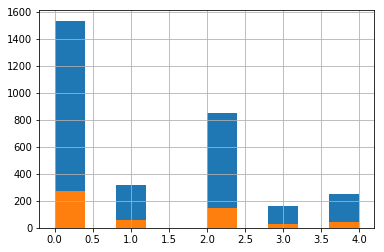

In [7]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=SEED)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

## 1.1 Simple picture to explain Diabetic Retinopathy

How do we know that a patient have diabetic retinopahy? There are 5 things to spot on. Image credit https://www.eyeops.com/
![credit : https://www.eyeops.com/](https://sa1s3optim.patientpop.com/assets/images/provider/photos/1947516.jpeg)

From quick investigations of the data (see various pictures below), I found that *Hemorrphages, Hard Exudates and Cotton Wool spots* are quite easily observed. However, I still could not find examples of *Aneurysm* or *Abnormal Growth of Blood Vessels* from our data yet. Perhaps the latter two cases are important if we want to catch up human benchmnark using our model.

## Process TFRecord

In [8]:
# Aquí transcribimos las imágenes a un fichero tipo TFRECORD de tamaño
width = 100 # 400
height = 125 # 500

size = (width,height)

image_x = []

for i in df_train['id_code']:
    path=f"{DATA_PATH}/processed_train_images/{i}.png"
    img = image.load_img(path, grayscale=True,target_size=(width,height,1))
    img = image.img_to_array(img)
    img = img/255
    image_x.append(img)
X = np.array(image_x)


In [9]:
print(len(x), X.shape)

3662 (3662, 100, 125, 1)


In [10]:
Y = to_categorical(df_train['diagnosis'].values)
print(len(Y), Y.shape)

3662 (3662, 5)


In [11]:
train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.2,
                                                      stratify=y, random_state=SEED)
print(train_X.shape, train_Y.shape, valid_X.shape, valid_Y.shape)

(2929, 100, 125, 1) (2929, 5) (733, 100, 125, 1) (733, 5)


# The Model
## inspired in real life

help obtained from
https://machinelearningmastery.com/keras-functional-api-deep-learning/


In [12]:
# config = tf.ConfigProto(device_count = {'GPU': 0})
# config.gpu_options.allow_growth = True
# gpu_options = tf.GPUOptions(allow_growth=True)

# session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [13]:
# ---------------------
# OPTION 1
# ---------------------
''' 

input_layer = tf.keras.Input(shape=(width,height,1))
print('input_layer: ', input_layer.shape)

layer1 = tf.keras.layers.Conv2D(1000, kernel_size=(5, 5), activation='relu')(input_layer)
print('layer: ', layer1.shape)

layer2 = tf.keras.layers.MaxPooling2D(pool_size=(5, 5))(layer1)
print('layer: ', layer2.shape)

layer3 = tf.keras.layers.Conv2D(500, kernel_size=(2, 2), activation='relu')(layer2)
print('layer: ', layer3.shape)

layer4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layer3)
print('layer: ', layer4.shape)

layer5 = tf.keras.layers.Conv2D(100, kernel_size=(2, 2), activation='relu')(layer4)
print('layer: ', layer5.shape)

layer6 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layer5)
print('layer: ', layer6.shape)

layer7 = tf.keras.layers.Flatten()(layer6)
print('layer: ', layer7.shape)

layer8 = tf.keras.layers.Dense(10*NUM_CLASSES, activation='relu')(layer7)
print('layer: ', layer8.shape)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(layer8)
print('output_layer: ', output_layer.shape)

model = tf.keras.Model(inputs = [input_layer], outputs = [output_layer])

'''

" \n\ninput_layer = tf.keras.Input(shape=(width,height,1))\nprint('input_layer: ', input_layer.shape)\n\nlayer1 = tf.keras.layers.Conv2D(100, kernel_size=(5, 5), activation='relu')(input_layer)\nprint('layer: ', layer1.shape)\n\nlayer2 = tf.keras.layers.MaxPooling2D(pool_size=(5, 5))(layer1)\nprint('layer: ', layer2.shape)\n\nlayer3 = tf.keras.layers.Conv2D(100, kernel_size=(2, 2), activation='relu')(layer2)\nprint('layer: ', layer3.shape)\n\nlayer4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layer3)\nprint('layer: ', layer4.shape)\n\nlayer5 = tf.keras.layers.Conv2D(100, kernel_size=(2, 2), activation='relu')(layer4)\nprint('layer: ', layer5.shape)\n\nlayer6 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layer5)\nprint('layer: ', layer6.shape)\n\nlayer7 = tf.keras.layers.Flatten()(layer6)\nprint('layer: ', layer7.shape)\n\nlayer8 = tf.keras.layers.Dense(10*NUM_CLASSES, activation='relu')(layer7)\nprint('layer: ', layer8.shape)\n\noutput_layer = tf.keras.layers.Dense(NUM_CLASSES,

In [14]:
# ---------------------
# OPTION 2
# ---------------------

''' '''


model = Sequential()

model.add(InputLayer((width,height,1)))
model.add(Conv2D(1000, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Conv2D(500, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(100, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(10*NUM_CLASSES, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))


Instructions for updating:
Colocations handled automatically by placer.


In [15]:
# import pydot
# import graphviz

print(model.summary())
# no va por alguna chuminada
# tf.keras.utils.plot_model(model, 'model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 121, 1000)     26000     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 24, 1000)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 23, 500)       2000500   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 11, 500)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 10, 100)        200100    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 5, 100)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2000)              0         
__________

In [16]:
# model.compile(optimizer=tf.train.AdamOptimizer(),
#              loss = tf.keras.losses.CategoricalCrossentropy())

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [17]:
import datetime
# este es el modelo estándar, con la entrada y la salida esperadas
# hay que sustituirlo por un iterador.


# No olvidarse de incluir un train_history para recuperar los datos del entrenamiento
# 5000 epochs es una locura y el número de steps per epoch es muy bajo (no se recorren todas las imagenes)
# el mínimo steps_per_epoch debería de ser total_muestras/batch_size

lt = datetime.datetime.now().strftime("%Y%m%d")
model_file = "/mnt/DATA-SSD/DataSandbox/model_{lt}_{epoch:04d}.h5"

# with callback
train_history = model.fit(train_X, train_Y,
                          batch_size = 10,
                          epochs=100,
                          verbose=1,
                          validation_data = (valid_X, valid_Y),
                          callbacks = [tf.keras.callbacks.ModelCheckpoint(model_file, 
                                                                          save_weights_only = False,
                                                                          verbose=1)])


Instructions for updating:
Use tf.cast instead.
Train on 2929 samples, validate on 733 samples
Epoch 1/100
2929/2929 [==============================] - 214s 73ms/step - loss: 0.9974 - acc: 0.6419 - val_loss: 0.8928 - val_acc: 0.6808

Epoch 00001: saving model to /mnt/DATA-SSD/DataSandbox/model0001.h5
Epoch 2/100
2929/2929 [==============================] - 212s 73ms/step - loss: 0.8467 - acc: 0.7074 - val_loss: 0.8052 - val_acc: 0.6930

Epoch 00002: saving model to /mnt/DATA-SSD/DataSandbox/model0002.h5
Epoch 3/100
2929/2929 [==============================] - 212s 72ms/step - loss: 0.8095 - acc: 0.7074 - val_loss: 0.7944 - val_acc: 0.7135

Epoch 00003: saving model to /mnt/DATA-SSD/DataSandbox/model0003.h5
Epoch 4/100
2929/2929 [==============================] - 201s 69ms/step - loss: 0.7859 - acc: 0.7115 - val_loss: 0.7571 - val_acc: 0.6985

Epoch 00004: saving model to /mnt/DATA-SSD/DataSandbox/model0004.h5
Epoch 5/100
2929/2929 [==============================] - 201s 69ms/step - los

2929/2929 [==============================] - 201s 69ms/step - loss: 0.0918 - acc: 0.9679 - val_loss: 2.1078 - val_acc: 0.7353

Epoch 00039: saving model to /mnt/DATA-SSD/DataSandbox/model0039.h5
Epoch 40/100
2929/2929 [==============================] - 201s 69ms/step - loss: 0.1004 - acc: 0.9665 - val_loss: 2.0528 - val_acc: 0.6999

Epoch 00040: saving model to /mnt/DATA-SSD/DataSandbox/model0040.h5
Epoch 41/100
2929/2929 [==============================] - 201s 68ms/step - loss: 0.1067 - acc: 0.9611 - val_loss: 1.9959 - val_acc: 0.7394

Epoch 00041: saving model to /mnt/DATA-SSD/DataSandbox/model0041.h5
Epoch 42/100
2929/2929 [==============================] - 201s 68ms/step - loss: 0.0644 - acc: 0.9788 - val_loss: 1.9226 - val_acc: 0.7271

Epoch 00042: saving model to /mnt/DATA-SSD/DataSandbox/model0042.h5
Epoch 43/100
2929/2929 [==============================] - 201s 69ms/step - loss: 0.0407 - acc: 0.9863 - val_loss: 1.9463 - val_acc: 0.7326

Epoch 00043: saving model to /mnt/DATA-SS

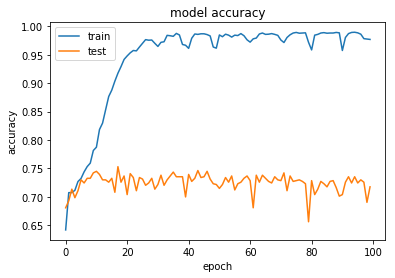

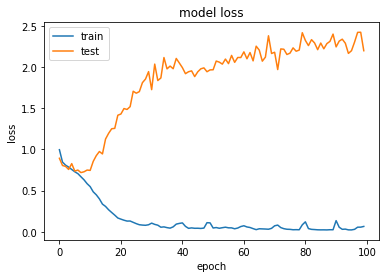

In [18]:
# summarize history for accuracy
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
model.evaluate(x=valid_X, y=valid_Y)

733/733 [==============================] - 11s 15ms/step


[2.202020035596694, 0.7175989089200799]

In [25]:
# Choose 5 random images one for each different diagnosis value

image_list = []
for class_id in sorted(train_y.unique()):
    image_list.append(df_train.loc[df_train['diagnosis'] == class_id].sample(1, random_state=SEED))

image_list

[           id_code  diagnosis
 1361  5ead17e894ae          0,            id_code  diagnosis
 3305  e580676516b0          1,           id_code  diagnosis
 520  2532613a584a          2,            id_code  diagnosis
 2200  9a94e0316ee3          3,          id_code  diagnosis
 88  07122e268a1d          4]

In [27]:
predict = {}
for image_data in image_list:
    path=f"{DATA_PATH}/processed_train_images/{image_data.iloc[0][0]}.png"
    img = image.load_img(path, grayscale=True,target_size=(width,height,1))
    img = image.img_to_array(img)
    img = img.reshape(1,width,height,1)

    predict[image_data.iloc[0][0]] = [image_data.iloc[0][1], model.predict(img)]
    
predict

{'5ead17e894ae': [0, array([[1., 0., 0., 0., 0.]], dtype=float32)],
 'e580676516b0': [1, array([[1., 0., 0., 0., 0.]], dtype=float32)],
 '2532613a584a': [2, array([[0., 0., 1., 0., 0.]], dtype=float32)],
 '9a94e0316ee3': [3, array([[0., 0., 1., 0., 0.]], dtype=float32)],
 '07122e268a1d': [4, array([[0., 0., 0., 0., 1.]], dtype=float32)]}

In [28]:
# extra training
model_file = "/mnt/DATA-SSD/DataSandbox/model_2_{epoch:04d}.h5"
train_history = model.fit(train_X, train_Y,
                          batch_size = 10,
                          epochs=100,
                          verbose=1,
                          validation_data = (valid_X, valid_Y),
                          callbacks = [tf.keras.callbacks.ModelCheckpoint(model_file, verbose=1)])


Train on 2929 samples, validate on 733 samples
Epoch 1/100
2929/2929 [==============================] - 212s 72ms/step - loss: 0.0244 - acc: 0.9884 - val_loss: 2.3269 - val_acc: 0.7258

Epoch 00001: saving model to /mnt/DATA-SSD/DataSandbox/model_2_0001.h5
Epoch 2/100
2929/2929 [==============================] - 212s 72ms/step - loss: 0.0211 - acc: 0.9884 - val_loss: 2.3431 - val_acc: 0.7340

Epoch 00002: saving model to /mnt/DATA-SSD/DataSandbox/model_2_0002.h5
Epoch 3/100
2929/2929 [==============================] - 211s 72ms/step - loss: 0.0214 - acc: 0.9881 - val_loss: 2.3908 - val_acc: 0.7353

Epoch 00003: saving model to /mnt/DATA-SSD/DataSandbox/model_2_0003.h5
Epoch 4/100
2929/2929 [==============================] - 201s 69ms/step - loss: 0.0220 - acc: 0.9894 - val_loss: 2.2882 - val_acc: 0.7299

Epoch 00004: saving model to /mnt/DATA-SSD/DataSandbox/model_2_0004.h5
Epoch 5/100
2929/2929 [==============================] - 201s 69ms/step - loss: 0.0225 - acc: 0.9870 - val_loss: 


Epoch 00039: saving model to /mnt/DATA-SSD/DataSandbox/model_2_0039.h5
Epoch 40/100
2929/2929 [==============================] - 201s 69ms/step - loss: 0.0194 - acc: 0.9877 - val_loss: 2.6730 - val_acc: 0.7231

Epoch 00040: saving model to /mnt/DATA-SSD/DataSandbox/model_2_0040.h5
Epoch 41/100
2929/2929 [==============================] - 201s 69ms/step - loss: 0.0161 - acc: 0.9911 - val_loss: 2.7183 - val_acc: 0.7231

Epoch 00041: saving model to /mnt/DATA-SSD/DataSandbox/model_2_0041.h5
Epoch 42/100
2929/2929 [==============================] - 201s 69ms/step - loss: 0.0164 - acc: 0.9884 - val_loss: 2.6634 - val_acc: 0.7121

Epoch 00042: saving model to /mnt/DATA-SSD/DataSandbox/model_2_0042.h5
Epoch 43/100
2929/2929 [==============================] - 201s 69ms/step - loss: 0.0172 - acc: 0.9908 - val_loss: 2.6181 - val_acc: 0.7190

Epoch 00043: saving model to /mnt/DATA-SSD/DataSandbox/model_2_0043.h5
Epoch 44/100
2929/2929 [==============================] - 201s 69ms/step - loss: 0.0


Epoch 00078: saving model to /mnt/DATA-SSD/DataSandbox/model_2_0078.h5
Epoch 79/100
2929/2929 [==============================] - 201s 69ms/step - loss: 0.0144 - acc: 0.9894 - val_loss: 2.5188 - val_acc: 0.7217

Epoch 00079: saving model to /mnt/DATA-SSD/DataSandbox/model_2_0079.h5
Epoch 80/100
2929/2929 [==============================] - 201s 69ms/step - loss: 0.0141 - acc: 0.9891 - val_loss: 2.5194 - val_acc: 0.7299

Epoch 00080: saving model to /mnt/DATA-SSD/DataSandbox/model_2_0080.h5
Epoch 81/100
2929/2929 [==============================] - 201s 69ms/step - loss: 0.0141 - acc: 0.9898 - val_loss: 2.5590 - val_acc: 0.7271

Epoch 00081: saving model to /mnt/DATA-SSD/DataSandbox/model_2_0081.h5
Epoch 82/100
2929/2929 [==============================] - 201s 69ms/step - loss: 0.0146 - acc: 0.9894 - val_loss: 2.5287 - val_acc: 0.7258

Epoch 00082: saving model to /mnt/DATA-SSD/DataSandbox/model_2_0082.h5
Epoch 83/100
2929/2929 [==============================] - 201s 69ms/step - loss: 0.0

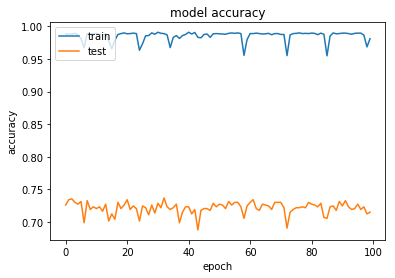

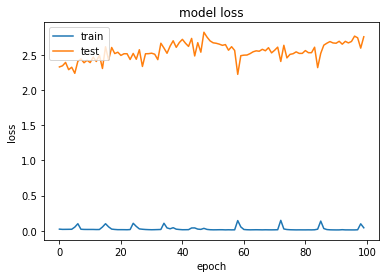

In [29]:
# summarize history for accuracy
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
model.evaluate(x=X, y=Y)

3662/3662 [==============================] - 55s 15ms/step


[0.5653299581203411, 0.9358274167447322]

In [43]:
# Choose 2 pairs of 5 random images one for each different diagnosis value

image_list = []
for class_id in sorted(train_y.unique()):
    image_list.append(df_train.loc[df_train['diagnosis'] == class_id].sample(1, random_state=SEED))

image_list

[           id_code  diagnosis
 1361  5ead17e894ae          0,            id_code  diagnosis
 3305  e580676516b0          1,           id_code  diagnosis
 520  2532613a584a          2,            id_code  diagnosis
 2200  9a94e0316ee3          3,          id_code  diagnosis
 88  07122e268a1d          4]

In [44]:
predict2 = {}

for image_data in image_list:
    path=f"{DATA_PATH}/processed_train_images/{image_data.iloc[0][0]}.png"
    img = image.load_img(path, grayscale=True,target_size=(width,height,1))
    img = image.img_to_array(img)
    img = img.reshape(1,width,height,1)

    predict2[image_data.iloc[0][0]] = [image_data.iloc[0][1], model.predict(img)]
    
predict

{'5ead17e894ae': [0, array([[1., 0., 0., 0., 0.]], dtype=float32)],
 'e580676516b0': [1, array([[0., 1., 0., 0., 0.]], dtype=float32)],
 '2532613a584a': [2, array([[0., 0., 1., 0., 0.]], dtype=float32)],
 '9a94e0316ee3': [3,
  array([[0.0000000e+00, 1.9314864e-17, 1.0000000e+00, 0.0000000e+00,
          0.0000000e+00]], dtype=float32)],
 '07122e268a1d': [4, array([[0., 0., 0., 0., 1.]], dtype=float32)]}

In [54]:
results_train = {}
for i in df_train.iterrows():
    path=f"{DATA_PATH}/processed_train_images/{i[1][0]}.png"
    img = image.load_img(path, grayscale=True,target_size=(width,height,1))
    img = image.img_to_array(img)
    img = img.reshape(1,width,height,1)

    results_train[i[0]] = [i[1][0], i[1][1], model.predict(img)]


In [55]:
results_df = pd.DataFrame.from_dict(results_train, 
                                    orient='index', 
                                    columns=['imge_id', 'diagnoses', 'prediction'])

In [95]:
def diagnoses_from_list(row):
    n = 0.0
    diagnoses = 0.0
    for i in row[0]:
        diagnoses += i*n
        n += 1.0
    return int(diagnoses)

In [99]:
# print(results_df.iloc[0][2])
# print(diagnoses_from_list(results_df.prediction[0]))
results_df['predicted_diagnoses'] = results_df.apply( lambda x: diagnoses_from_list(x.prediction), axis=1)
results_df['prediction_error'] = results_df['diagnoses'].sub(results_df['predicted_diagnoses'])
results_df.sum(axis=0)
# results_df

imge_id                000c1434d8d7001639a390f00024cdab0c1e002c21358c...
diagnoses                                                           4127
prediction             [[1781.1736, 314.36664, 1078.1989, 133.97585, ...
predicted_diagnoses                                                 4273
prediction_error                                                    -146
dtype: object

In [102]:
results_test = {}
for i in df_test.iterrows():
    path=f"{DATA_PATH}/processed_test_images/{i[1][0]}.png"
    img = image.load_img(path, grayscale=True,target_size=(width,height,1))
    img = image.img_to_array(img)
    img = img.reshape(1,width,height,1)

    results_test[i[0]] = [i[1][0], model.predict(img)]

In [103]:
results_test_df = pd.DataFrame.from_dict(results_test, 
                                    orient='index', 
                                    columns=['imge_id', 'prediction'])

In [104]:
# print(results_df.iloc[0][2])
# print(diagnoses_from_list(results_df.prediction[0]))
results_test_df['predicted_diagnoses'] = results_test_df.apply( 
    lambda x: diagnoses_from_list(x.prediction), axis=1)
# results_df

In [106]:
lt = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
results_df.to_pickle(f"{DATA_PATH}/results_df_{lt}.pkl")
results_df.to_pickle(f"{DATA_PATH}/results_test_df_{lt}.pkl")